In [4]:
# %% [markdown]
# # Final Model Evaluation & Actionable Insights
# 
# This notebook evaluates the best Gradient Boosting and Logistic Regression models
# on the final test set, interprets results, and extracts actionable insights
# for power outage prediction deployment.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import shap

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
print("=" * 70)
print("LOADING FINAL TEST DATA")
print("=" * 70)

PROCESSED = Path("../../data/processed/month_stratified_splits")

test_df = pd.read_csv(PROCESSED / "test_data.csv")
print(f"Test set shape: {test_df.shape}")
print(f"Outage rate in test set: {test_df['outage_occurred'].mean():.3f}")

# Check data distribution
print("\nTest set statistics:")
print(f"Date range: {test_df['date'].min()} to {test_df['date'].max()}")
print(f"Total samples: {len(test_df):,}")
print(f"Outage samples: {test_df['outage_occurred'].sum():,}")
print(f"No-outage samples: {(test_df['outage_occurred'] == 0).sum():,}")

# Monthly distribution
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['month'] = test_df['date'].dt.month
print("\nMonthly distribution in test set:")
print(test_df['month'].value_counts().sort_index())

LOADING FINAL TEST DATA
Test set shape: (73292, 9)
Outage rate in test set: 0.094

Test set statistics:
Date range: 2014-01-01 to 2014-12-31
Total samples: 73,292
Outage samples: 6,879
No-outage samples: 66,413

Monthly distribution in test set:
month
1     6225
2     5622
3     6225
4     6024
5     6225
6     6024
7     6225
8     6225
9     6024
10    6224
11    6024
12    6225
Name: count, dtype: int64


In [6]:
print("\n" + "=" * 70)
print("LOADING BEST MODELS")
print("=" * 70)

MODELS_DIR = Path("../../models")

# Try to load the best (tuned) models first, fall back to original
def load_best_model(model_type):
    """Load the best available model for a given type"""
    model_paths = [
        MODELS_DIR / f"{model_type}_tuned" / f"{model_type}_tuned.pkl",
        MODELS_DIR / model_type / f"{model_type}_model.pkl"
    ]
    
    scaler_paths = [
        MODELS_DIR / f"{model_type}_tuned" / "feature_scaler.pkl",
        MODELS_DIR / model_type / "feature_scaler.pkl"
    ]
    
    for model_path, scaler_path in zip(model_paths, scaler_paths):
        if model_path.exists():
            try:
                model = joblib.load(model_path)
                scaler = joblib.load(scaler_path)
                print(f"✅ Loaded {model_type} from: {model_path}")
                return model, scaler
            except Exception as e:
                print(f"⚠️  Error loading {model_path}: {e}")
    
    print(f"❌ Could not load {model_type} model")
    return None, None

# Load models
gb_model, gb_scaler = load_best_model("gradient_boosting")
lr_model, lr_scaler = load_best_model("logistic_regression")

print("\nModel specifications:")
if gb_model:
    print(f"Gradient Boosting: {gb_model}")
if lr_model:
    print(f"Logistic Regression: {lr_model}")



LOADING BEST MODELS
✅ Loaded gradient_boosting from: ../../models/gradient_boosting_tuned/gradient_boosting_tuned.pkl
✅ Loaded logistic_regression from: ../../models/logistic_regression_tuned/logistic_regression_tuned.pkl

Model specifications:
Gradient Boosting: GradientBoostingClassifier(learning_rate=0.2, max_depth=7, min_samples_leaf=10,
                           min_samples_split=100, n_estimators=50,
                           random_state=42)
Logistic Regression: LogisticRegression(C=0.001, class_weight='balanced', l1_ratio=0.3,
                   max_iter=2000, penalty='l1', random_state=42, solver='saga',
                   tol=0.001)


In [7]:
print("\n" + "=" * 70)
print("PREPARING FEATURES")
print("=" * 70)

def prepare_features(test_df):
    """Prepare features for modeling"""
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    
    # Get feature columns (use the same as training)
    feature_cols = [col for col in test_df.columns if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features")
    print(f"Feature names: {feature_cols}")
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    return X_test.values, y_test.values, feature_cols

X_test, y_test, feature_cols = prepare_features(test_df)

print(f"\nFeature matrix shape: {X_test.shape}")
print(f"Target vector shape: {y_test.shape}")


PREPARING FEATURES
Using 5 features
Feature names: ['tmin', 'prcp', 'season', 'day_of_week', 'day_name']

Feature matrix shape: (73292, 5)
Target vector shape: (73292,)


In [8]:
print("\n" + "=" * 70)
print("SCALING DATA")
print("=" * 70)

def scale_data(scaler, X_data, model_name):
    """Scale data for model"""
    try:
        X_scaled = scaler.transform(X_data)
        print(f"✅ Scaled data for {model_name}")
        return X_scaled
    except Exception as e:
        print(f"❌ Error scaling for {model_name}: {e}")
        return None

X_test_gb = scale_data(gb_scaler, X_test, "Gradient Boosting") if gb_scaler else None
X_test_lr = scale_data(lr_scaler, X_test, "Logistic Regression") if lr_scaler else None


SCALING DATA
✅ Scaled data for Gradient Boosting
✅ Scaled data for Logistic Regression


In [9]:
print("\n" + "=" * 70)
print("MAKING PREDICTIONS ON TEST SET")
print("=" * 70)

def make_predictions(model, X_scaled, model_name):
    """Make predictions with a model"""
    if model is None or X_scaled is None:
        print(f"❌ Cannot make predictions for {model_name} - model or data missing")
        return None, None, None
    
    try:
        y_pred = model.predict(X_scaled)
        y_proba = model.predict_proba(X_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        print(f"✅ Made predictions for {model_name}")
        return y_pred, y_proba, model
    except Exception as e:
        print(f"❌ Error making predictions for {model_name}: {e}")
        return None, None, None

# Make predictions
gb_pred, gb_proba, gb_model_used = make_predictions(gb_model, X_test_gb, "Gradient Boosting")
lr_pred, lr_proba, lr_model_used = make_predictions(lr_model, X_test_lr, "Logistic Regression")


MAKING PREDICTIONS ON TEST SET
✅ Made predictions for Gradient Boosting
✅ Made predictions for Logistic Regression


In [10]:
print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Comprehensive model evaluation"""
    
    print(f"\n📊 EVALUATION RESULTS: {model_name.upper()}")
    print("-" * 60)
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}  ← Most important for outage detection")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Probability-based metrics
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        avg_precision = average_precision_score(y_true, y_proba)
        
        print(f"ROC-AUC:   {roc_auc:.4f}")
        print(f"Avg Precision: {avg_precision:.4f}")
    else:
        roc_auc = None
        avg_precision = None
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📈 Confusion Matrix:")
    print(f"True Negatives:  {tn:>8,} (Correct non-outages)")
    print(f"False Positives: {fp:>8,} (False alarms)")
    print(f"False Negatives: {fn:>8,} (Missed outages) ← Most critical")
    print(f"True Positives:  {tp:>8,} (Detected outages)")
    
    # Calculate rates
    total_outages = tp + fn
    total_non_outages = tn + fp
    
    detection_rate = tp / total_outages if total_outages > 0 else 0
    false_alarm_rate = fp / total_non_outages if total_non_outages > 0 else 0
    
    print(f"\n🎯 Key Rates:")
    print(f"Outage Detection Rate: {detection_rate:.3f} ({tp:,}/{total_outages:,} outages detected)")
    print(f"False Alarm Rate:      {false_alarm_rate:.3f} ({fp:,}/{total_non_outages:,} false alarms)")
    print(f"Precision Rate:        {precision:.3f} ({tp:,}/{tp+fp:,} outage predictions correct)")
    
    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm,
        'detection_rate': detection_rate,
        'false_alarm_rate': false_alarm_rate,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

# Evaluate both models
gb_metrics = None
lr_metrics = None

if gb_pred is not None:
    gb_metrics = evaluate_model(y_test, gb_pred, gb_proba, "Gradient Boosting")

if lr_pred is not None:
    lr_metrics = evaluate_model(y_test, lr_pred, lr_proba, "Logistic Regression")


COMPREHENSIVE MODEL EVALUATION

📊 EVALUATION RESULTS: GRADIENT BOOSTING
------------------------------------------------------------
Accuracy:  0.8723
Recall:    0.0065  ← Most important for outage detection
Precision: 0.0175
F1-Score:  0.0095
ROC-AUC:   0.5122
Avg Precision: 0.0935

📈 Confusion Matrix:
True Negatives:    63,885 (Correct non-outages)
False Positives:    2,528 (False alarms)
False Negatives:    6,834 (Missed outages) ← Most critical
True Positives:        45 (Detected outages)

🎯 Key Rates:
Outage Detection Rate: 0.007 (45/6,879 outages detected)
False Alarm Rate:      0.038 (2,528/66,413 false alarms)
Precision Rate:        0.017 (45/2,573 outage predictions correct)

📊 EVALUATION RESULTS: LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy:  0.6210
Recall:    0.2797  ← Most important for outage detection
Precision: 0.0777
F1-Score:  0.1217
ROC-AUC:   0.4590
Avg Precision: 0.0803

📈 Confusion Matrix:
True Negatives:    43,588 (Cor


MODEL COMPARISON VISUALIZATION


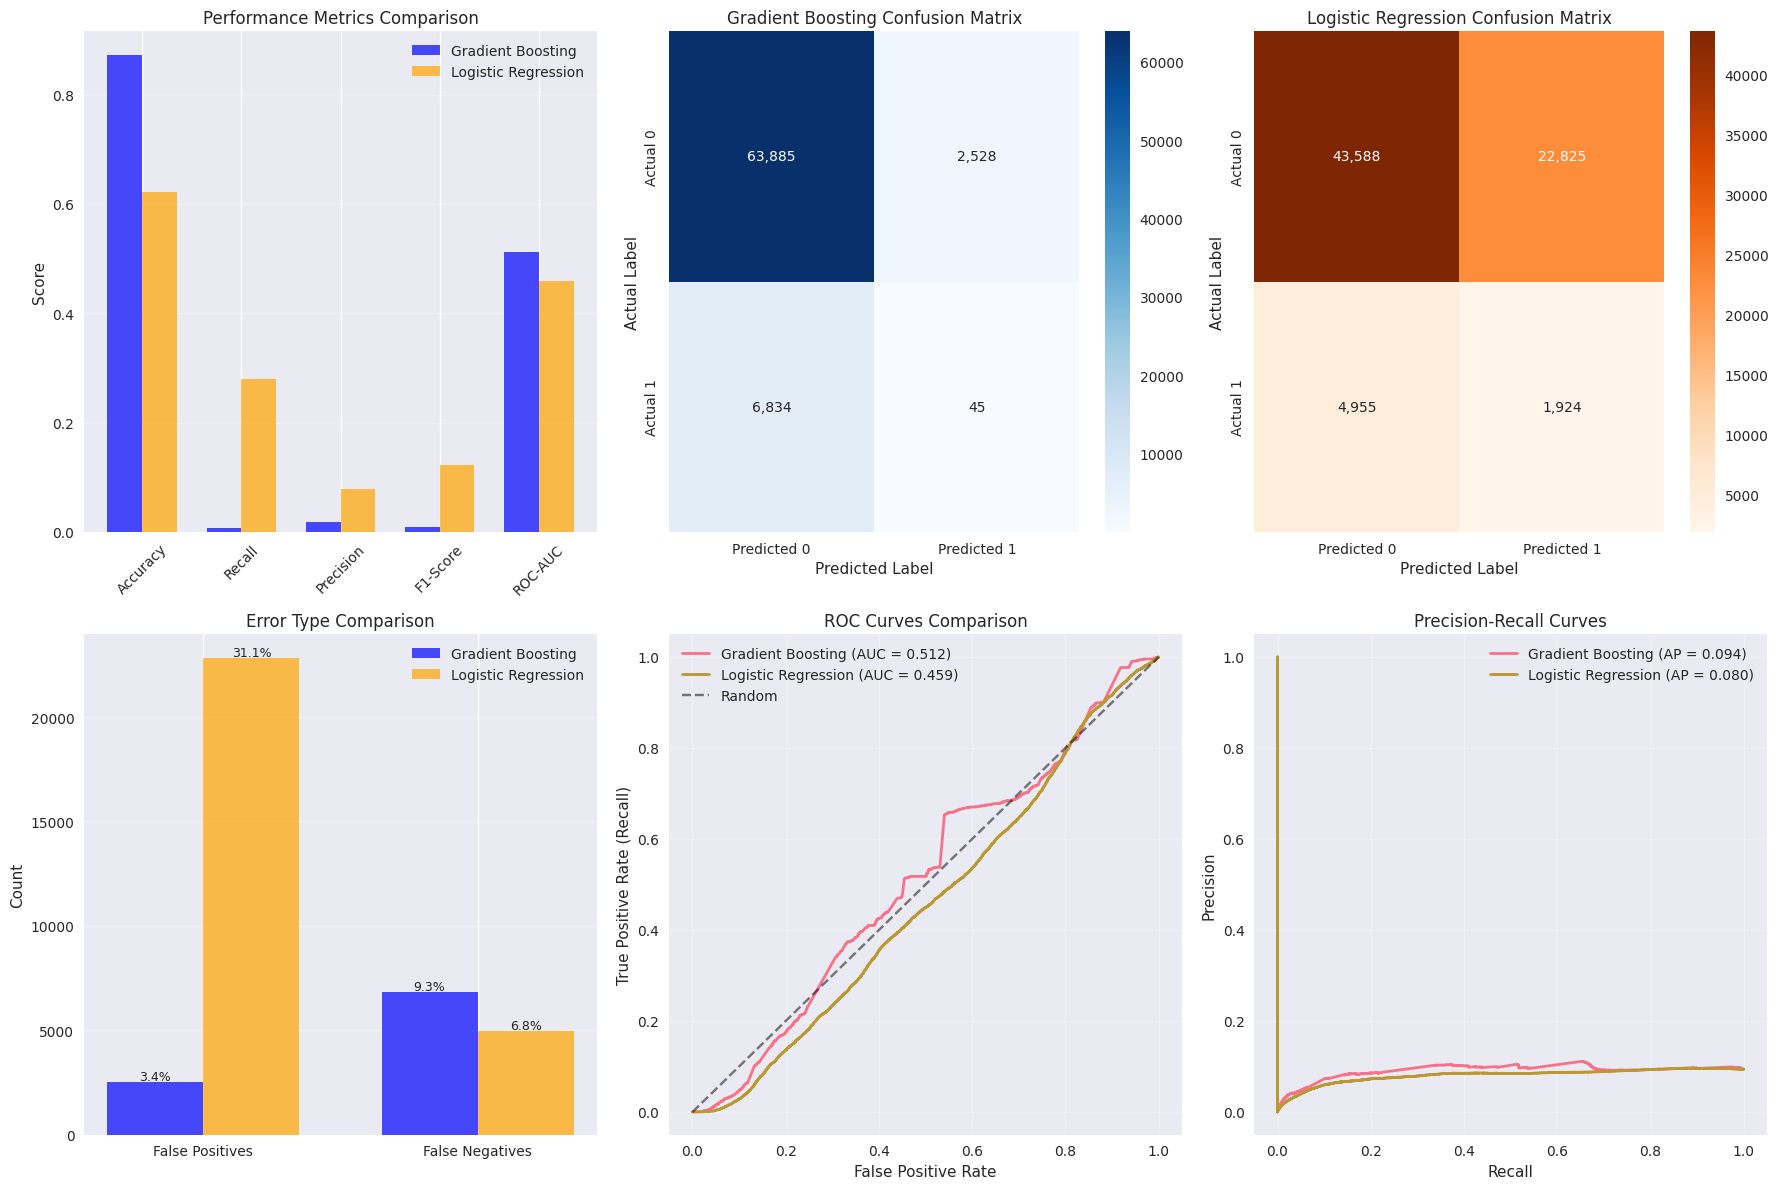


📊 DETAILED MODEL COMPARISON:
------------------------------------------------------------
Metric                    Gradient Boosting    Logistic Regression  Difference (GB-LR)  
-------------------------------------------------------------------------------------
Accuracy                  0.8723               0.6210               +0.2513
Recall                    0.0065               0.2797               -0.2732
Precision                 0.0175               0.0777               -0.0603
F1-Score                  0.0095               0.1217               -0.1121
ROC-AUC                   0.5122               0.4590               +0.0531

🎯 BUSINESS IMPACT COMPARISON:
------------------------------------------------------------
Outage Detection (Recall):
  • GB detects 45 of 6,879 outages (0.7%)
  • LR detects 1,924 of 6,879 outages (28.0%)
  • Difference: -0.273

False Alarms (Precision):
  • GB has 2,528 false alarms (1.7% correct predictions)
  • LR has 22,825 false alarms (7.8% cor

In [11]:
print("\n" + "=" * 70)
print("MODEL COMPARISON VISUALIZATION")
print("=" * 70)

if gb_metrics and lr_metrics:
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Performance metrics comparison
    metrics_to_compare = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
    metric_names = ['Accuracy', 'Recall', 'Precision', 'F1-Score', 'ROC-AUC']
    
    gb_values = [gb_metrics[m] for m in metrics_to_compare if gb_metrics[m] is not None]
    lr_values = [lr_metrics[m] for m in metrics_to_compare if lr_metrics[m] is not None]
    available_metrics = [m for m in metric_names if gb_metrics[metrics_to_compare[metric_names.index(m)]] is not None]
    
    x = np.arange(len(available_metrics))
    width = 0.35
    
    axes[0,0].bar(x - width/2, gb_values[:len(available_metrics)], width, 
                  label='Gradient Boosting', color='blue', alpha=0.7)
    axes[0,0].bar(x + width/2, lr_values[:len(available_metrics)], width, 
                  label='Logistic Regression', color='orange', alpha=0.7)
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(available_metrics, rotation=45)
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_title('Performance Metrics Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    
    # 2. Confusion matrix heatmaps
    gb_cm = gb_metrics['confusion_matrix']
    lr_cm = lr_metrics['confusion_matrix']
    
    # Gradient Boosting confusion matrix
    sns.heatmap(gb_cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0,1],
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    axes[0,1].set_title('Gradient Boosting Confusion Matrix')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('Actual Label')
    
    # Logistic Regression confusion matrix
    sns.heatmap(lr_cm, annot=True, fmt=',d', cmap='Oranges', ax=axes[0,2],
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    axes[0,2].set_title('Logistic Regression Confusion Matrix')
    axes[0,2].set_xlabel('Predicted Label')
    axes[0,2].set_ylabel('Actual Label')
    
    # 3. Error analysis
    error_types = ['False Positives', 'False Negatives']
    gb_errors = [gb_metrics['fp'], gb_metrics['fn']]
    lr_errors = [lr_metrics['fp'], lr_metrics['fn']]
    
    x = np.arange(len(error_types))
    axes[1,0].bar(x - width/2, gb_errors, width, label='Gradient Boosting', 
                  color='blue', alpha=0.7)
    axes[1,0].bar(x + width/2, lr_errors, width, label='Logistic Regression', 
                  color='orange', alpha=0.7)
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(error_types)
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Error Type Comparison')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # Add percentages
    for i, (gb_err, lr_err) in enumerate(zip(gb_errors, lr_errors)):
        total_samples = len(y_test)
        axes[1,0].text(i - width/2, gb_err + 100, f'{gb_err/total_samples:.1%}', 
                      ha='center', fontsize=9)
        axes[1,0].text(i + width/2, lr_err + 100, f'{lr_err/total_samples:.1%}', 
                      ha='center', fontsize=9)
    
    # 4. ROC Curves
    if gb_proba is not None and lr_proba is not None:
        fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
        fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
        
        axes[1,1].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_metrics["roc_auc"]:.3f})', 
                      linewidth=2)
        axes[1,1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["roc_auc"]:.3f})', 
                      linewidth=2)
        axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
        axes[1,1].set_xlabel('False Positive Rate')
        axes[1,1].set_ylabel('True Positive Rate (Recall)')
        axes[1,1].set_title('ROC Curves Comparison')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    # 5. Precision-Recall Curves
    if gb_proba is not None and lr_proba is not None:
        precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb_proba)
        precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_proba)
        
        axes[1,2].plot(recall_gb, precision_gb, 
                      label=f'Gradient Boosting (AP = {gb_metrics["avg_precision"]:.3f})', 
                      linewidth=2)
        axes[1,2].plot(recall_lr, precision_lr, 
                      label=f'Logistic Regression (AP = {lr_metrics["avg_precision"]:.3f})', 
                      linewidth=2)
        axes[1,2].set_xlabel('Recall')
        axes[1,2].set_ylabel('Precision')
        axes[1,2].set_title('Precision-Recall Curves')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n📊 DETAILED MODEL COMPARISON:")
    print("-" * 60)
    print(f"{'Metric':<25} {'Gradient Boosting':<20} {'Logistic Regression':<20} {'Difference (GB-LR)':<20}")
    print("-" * 85)
    
    for metric, name in zip(metrics_to_compare, metric_names):
        if gb_metrics[metric] is not None and lr_metrics[metric] is not None:
            diff = gb_metrics[metric] - lr_metrics[metric]
            print(f"{name:<25} {gb_metrics[metric]:<20.4f} {lr_metrics[metric]:<20.4f} {diff:+.4f}")
    
    # Business impact comparison
    print("\n🎯 BUSINESS IMPACT COMPARISON:")
    print("-" * 60)
    print(f"Outage Detection (Recall):")
    print(f"  • GB detects {gb_metrics['tp']:,} of {gb_metrics['tp']+gb_metrics['fn']:,} outages ({gb_metrics['recall']:.1%})")
    print(f"  • LR detects {lr_metrics['tp']:,} of {lr_metrics['tp']+lr_metrics['fn']:,} outages ({lr_metrics['recall']:.1%})")
    print(f"  • Difference: {gb_metrics['recall'] - lr_metrics['recall']:+.3f}")
    
    print(f"\nFalse Alarms (Precision):")
    print(f"  • GB has {gb_metrics['fp']:,} false alarms ({gb_metrics['precision']:.1%} correct predictions)")
    print(f"  • LR has {lr_metrics['fp']:,} false alarms ({lr_metrics['precision']:.1%} correct predictions)")
    print(f"  • Difference: {gb_metrics['precision'] - lr_metrics['precision']:+.3f}")


PROBABILITY DISTRIBUTION ANALYSIS


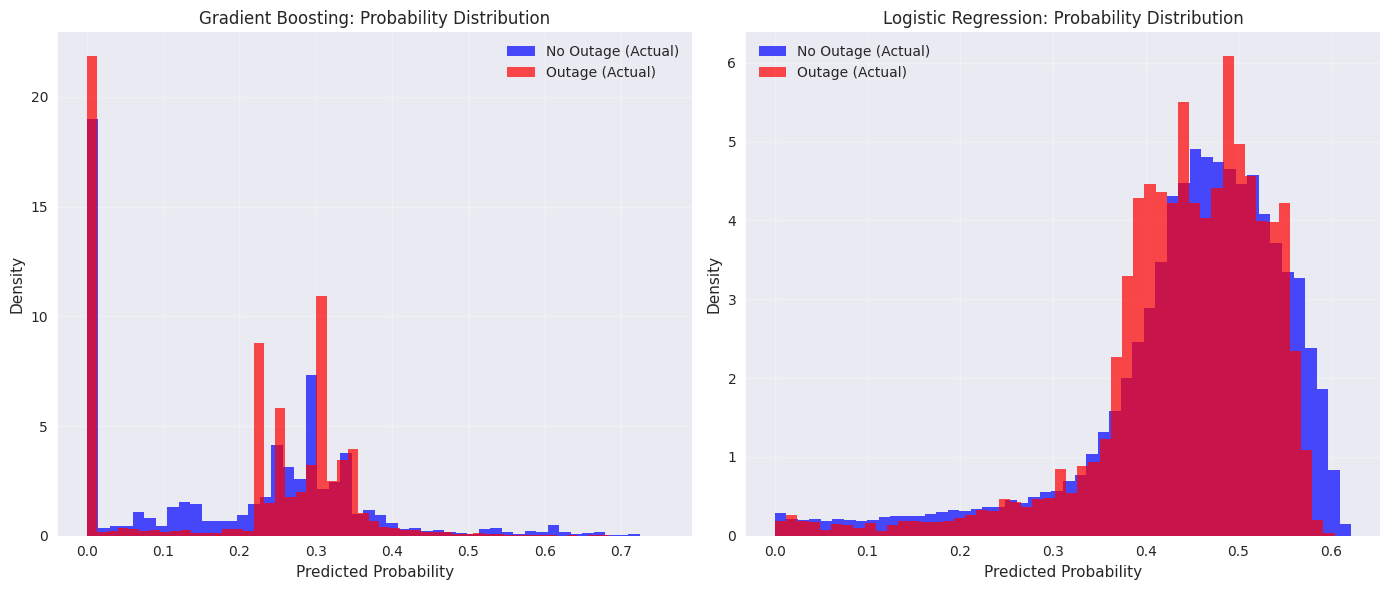


📊 PROBABILITY SEPARATION ANALYSIS:
------------------------------------------------------------

Gradient Boosting:
  Outage predictions: mean = 0.198, std = 0.143
  No-outage predictions: mean = 0.197, std = 0.159
  Separation (mean difference): 0.001

Logistic Regression:
  Outage predictions: mean = 0.441, std = 0.096
  No-outage predictions: mean = 0.448, std = 0.110
  Separation (mean difference): -0.007


In [12]:
print("\n" + "=" * 70)
print("PROBABILITY DISTRIBUTION ANALYSIS")
print("=" * 70)

if gb_proba is not None or lr_proba is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gradient Boosting probability distribution
    if gb_proba is not None:
        axes[0].hist(gb_proba[y_test == 0], bins=50, alpha=0.7, 
                    label='No Outage (Actual)', color='blue', density=True)
        axes[0].hist(gb_proba[y_test == 1], bins=50, alpha=0.7, 
                    label='Outage (Actual)', color='red', density=True)
        axes[0].set_xlabel('Predicted Probability')
        axes[0].set_ylabel('Density')
        axes[0].set_title('Gradient Boosting: Probability Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    # Logistic Regression probability distribution
    if lr_proba is not None:
        axes[1].hist(lr_proba[y_test == 0], bins=50, alpha=0.7, 
                    label='No Outage (Actual)', color='blue', density=True)
        axes[1].hist(lr_proba[y_test == 1], bins=50, alpha=0.7, 
                    label='Outage (Actual)', color='red', density=True)
        axes[1].set_xlabel('Predicted Probability')
        axes[1].set_ylabel('Density')
        axes[1].set_title('Logistic Regression: Probability Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze probability separation
    print("\n📊 PROBABILITY SEPARATION ANALYSIS:")
    print("-" * 60)
    
    if gb_proba is not None:
        gb_outage_probs = gb_proba[y_test == 1]
        gb_no_outage_probs = gb_proba[y_test == 0]
        
        print(f"\nGradient Boosting:")
        print(f"  Outage predictions: mean = {np.mean(gb_outage_probs):.3f}, std = {np.std(gb_outage_probs):.3f}")
        print(f"  No-outage predictions: mean = {np.mean(gb_no_outage_probs):.3f}, std = {np.std(gb_no_outage_probs):.3f}")
        print(f"  Separation (mean difference): {np.mean(gb_outage_probs) - np.mean(gb_no_outage_probs):.3f}")
    
    if lr_proba is not None:
        lr_outage_probs = lr_proba[y_test == 1]
        lr_no_outage_probs = lr_proba[y_test == 0]
        
        print(f"\nLogistic Regression:")
        print(f"  Outage predictions: mean = {np.mean(lr_outage_probs):.3f}, std = {np.std(lr_outage_probs):.3f}")
        print(f"  No-outage predictions: mean = {np.mean(lr_no_outage_probs):.3f}, std = {np.std(lr_no_outage_probs):.3f}")
        print(f"  Separation (mean difference): {np.mean(lr_outage_probs) - np.mean(lr_no_outage_probs):.3f}")


THRESHOLD OPTIMIZATION FOR BUSINESS NEEDS

📊 Gradient Boosting - Threshold Optimization:
--------------------------------------------------

Max Recall:
  Threshold: 0.010
  Recall: 0.702
  Precision: 0.092
  F1-Score: 0.163

Max Precision:
  Threshold: 0.222
  Recall: 0.654
  Precision: 0.111
  F1-Score: 0.190

Max F1:
  Threshold: 0.222
  Recall: 0.654
  Precision: 0.111
  F1-Score: 0.190

Balanced:
  Threshold: 0.687
  Recall: 0.000
  Precision: 0.000
  F1-Score: 0.000


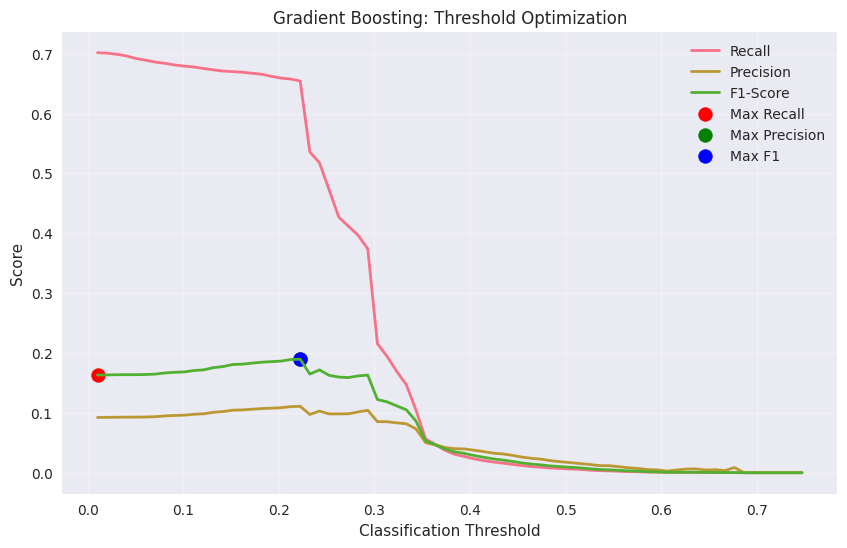


📊 Logistic Regression - Threshold Optimization:
--------------------------------------------------

Max Recall:
  Threshold: 0.010
  Recall: 0.998
  Precision: 0.094
  F1-Score: 0.172

Max Precision:
  Threshold: 0.354
  Recall: 0.888
  Precision: 0.096
  F1-Score: 0.173

Max F1:
  Threshold: 0.242
  Recall: 0.956
  Precision: 0.095
  F1-Score: 0.174

Balanced:
  Threshold: 0.606
  Recall: 0.000
  Precision: 0.000
  F1-Score: 0.000


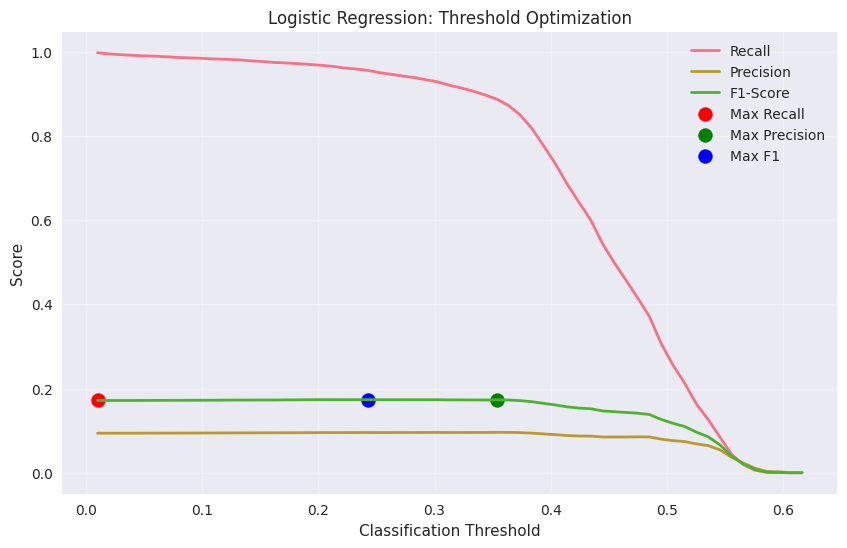

In [13]:
print("\n" + "=" * 70)
print("THRESHOLD OPTIMIZATION FOR BUSINESS NEEDS")
print("=" * 70)

def optimize_threshold(y_true, y_proba, model_name):
    """Find optimal thresholds for different business needs"""
    if y_proba is None:
        return None
    
    thresholds = np.linspace(0, 1, 100)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        
        if len(np.unique(y_pred)) > 1:  # Ensure we have both classes
            recall_val = recall_score(y_true, y_pred)
            precision_val = precision_score(y_true, y_pred)
            f1_val = f1_score(y_true, y_pred)
            
            results.append({
                'threshold': thresh,
                'recall': recall_val,
                'precision': precision_val,
                'f1': f1_val
            })
    
    results_df = pd.DataFrame(results)
    
    # Find optimal thresholds for different objectives
    optimal_thresholds = {
        'max_recall': results_df.loc[results_df['recall'].idxmax()],
        'max_precision': results_df.loc[results_df['precision'].idxmax()],
        'max_f1': results_df.loc[results_df['f1'].idxmax()],
        'balanced': results_df.loc[np.abs(results_df['recall'] - results_df['precision']).idxmin()]
    }
    
    print(f"\n📊 {model_name} - Threshold Optimization:")
    print("-" * 50)
    
    for strategy, row in optimal_thresholds.items():
        print(f"\n{strategy.replace('_', ' ').title()}:")
        print(f"  Threshold: {row['threshold']:.3f}")
        print(f"  Recall: {row['recall']:.3f}")
        print(f"  Precision: {row['precision']:.3f}")
        print(f"  F1-Score: {row['f1']:.3f}")
    
    # Plot threshold analysis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2)
    ax.plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
    ax.plot(results_df['threshold'], results_df['f1'], label='F1-Score', linewidth=2)
    
    # Mark optimal points
    for strategy, color in zip(['max_recall', 'max_precision', 'max_f1'], ['red', 'green', 'blue']):
        row = optimal_thresholds[strategy]
        ax.scatter(row['threshold'], row['f1'], color=color, s=100, 
                  label=f'{strategy.replace("_", " ").title()}')
    
    ax.set_xlabel('Classification Threshold')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name}: Threshold Optimization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return optimal_thresholds

# Optimize thresholds for both models
gb_thresholds = optimize_threshold(y_test, gb_proba, "Gradient Boosting") if gb_proba is not None else None
lr_thresholds = optimize_threshold(y_test, lr_proba, "Logistic Regression") if lr_proba is not None else None


FEATURE IMPORTANCE & INTERPRETABILITY

🔍 Gradient Boosting - Feature Analysis:
--------------------------------------------------
Top 10 most important features:
   1. prcp                 : 0.4569
   2. day_name             : 0.4450
   3. tmin                 : 0.0524
   4. season               : 0.0311
   5. day_of_week          : 0.0146


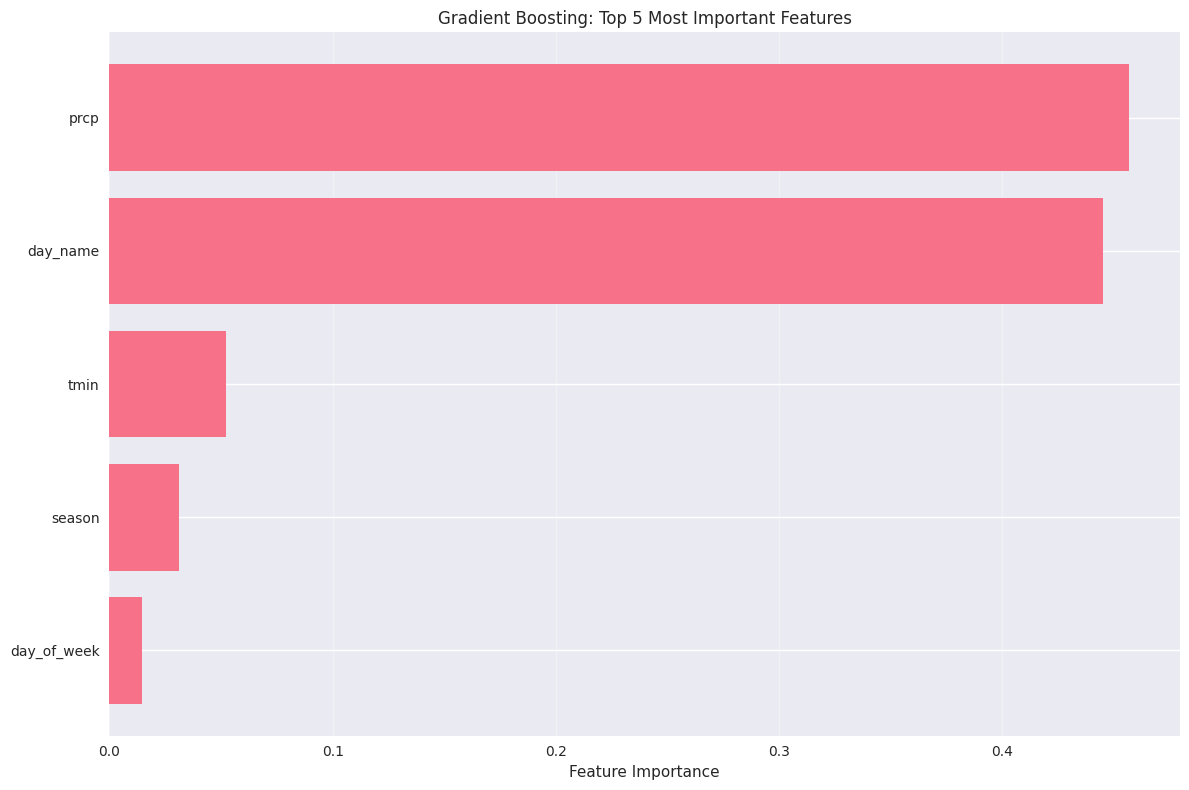


Performing SHAP analysis...


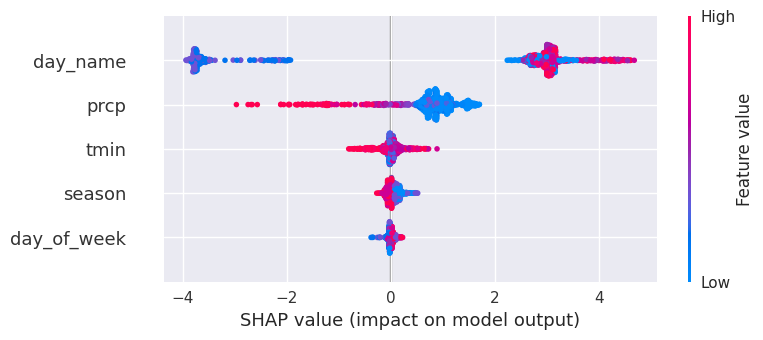


🔍 Logistic Regression - Feature Analysis:
--------------------------------------------------
Top 10 most influential features (by absolute coefficient):
   1. prcp                 : -0.9491
   2. day_name             : -0.1159
   3. tmin                 : +0.0679
   4. season               : -0.0481
   5. day_of_week          : -0.0002


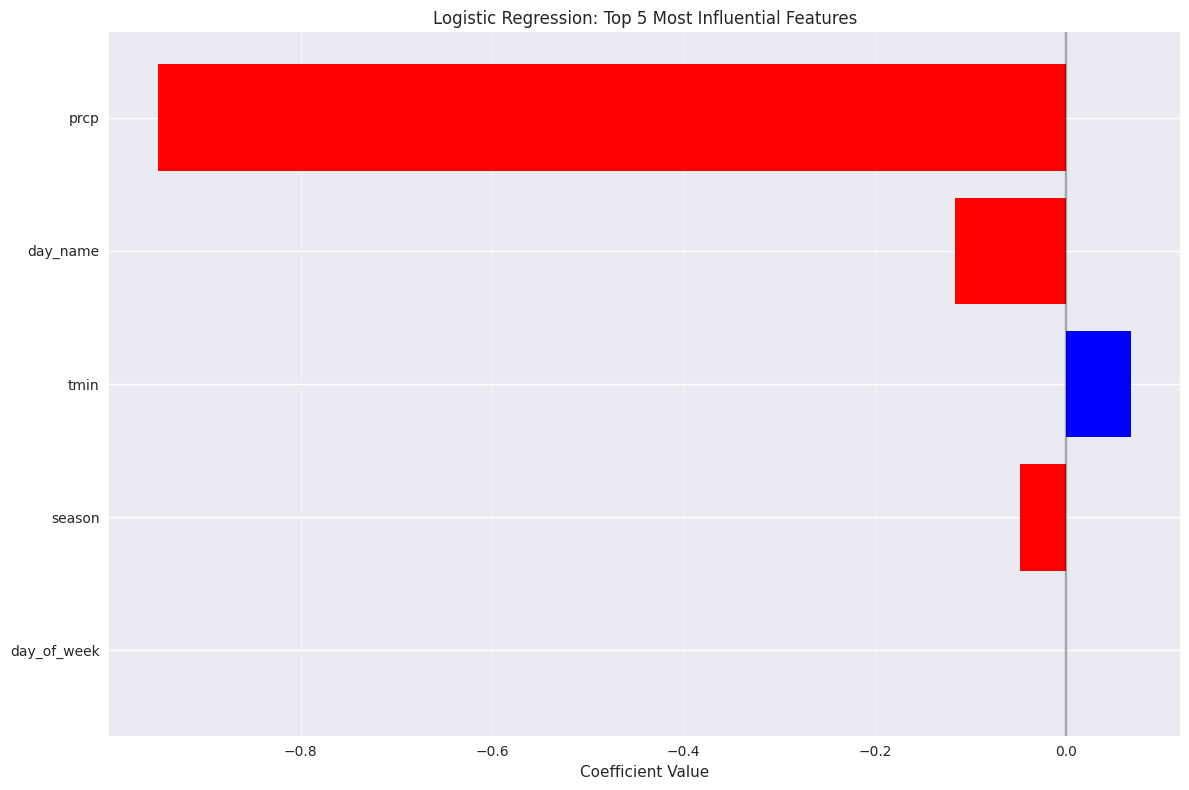

In [14]:
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE & INTERPRETABILITY")
print("=" * 70)

def analyze_feature_importance(model, feature_names, model_name, X_sample=None):
    """Analyze feature importance for model interpretability"""
    
    print(f"\n🔍 {model_name} - Feature Analysis:")
    print("-" * 50)
    
    # Gradient Boosting feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print(f"Top 10 most important features:")
        for i in range(min(10, len(feature_names))):
            print(f"  {i+1:2d}. {feature_names[indices[i]]:20s} : {importances[indices[i]]:.4f}")
        
        # Plot feature importance
        fig, ax = plt.subplots(figsize=(12, 8))
        
        top_n = min(15, len(feature_names))
        top_indices = indices[:top_n]
        
        ax.barh(range(top_n), importances[top_indices][::-1])
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in top_indices][::-1])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'{model_name}: Top {top_n} Most Important Features')
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        # SHAP analysis for deeper interpretability
        if X_sample is not None and len(feature_names) <= 20:  # SHAP works best with fewer features
            try:
                import shap
                print(f"\nPerforming SHAP analysis...")
                
                # Use a subset for faster computation
                X_sample_shap = X_sample[:1000] if len(X_sample) > 1000 else X_sample
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_sample_shap)
                
                # Summary plot
                fig, ax = plt.subplots(figsize=(12, 8))
                shap.summary_plot(shap_values, X_sample_shap, feature_names=feature_names, 
                                 show=False, max_display=10)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"SHAP analysis failed: {e}")
    
    # Logistic Regression coefficients
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        
        print(f"Top 10 most influential features (by absolute coefficient):")
        for i in range(min(10, len(feature_names))):
            idx = indices[i]
            sign = '+' if coefficients[idx] > 0 else '-'
            print(f"  {i+1:2d}. {feature_names[idx]:20s} : {sign}{abs(coefficients[idx]):.4f}")
        
        # Plot coefficients
        fig, ax = plt.subplots(figsize=(12, 8))
        
        top_n = min(15, len(feature_names))
        top_indices = indices[:top_n]
        
        colors = ['red' if coefficients[i] < 0 else 'blue' for i in top_indices]
        ax.barh(range(top_n), coefficients[top_indices][::-1], color=colors[::-1])
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in top_indices][::-1])
        ax.set_xlabel('Coefficient Value')
        ax.set_title(f'{model_name}: Top {top_n} Most Influential Features')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

# Analyze feature importance
if gb_model_used is not None:
    analyze_feature_importance(gb_model_used, feature_cols, "Gradient Boosting", X_test_gb)

if lr_model_used is not None:
    analyze_feature_importance(lr_model_used, feature_cols, "Logistic Regression", X_test_lr)

In [17]:
print("\n" + "=" * 70)
print("ACTIONABLE INSIGHTS & RECOMMENDATIONS")
print("=" * 70)
def generate_actionable_insights(gb_metrics, lr_metrics, gb_thresholds, lr_thresholds):
    """Generate actionable business insights from model evaluation"""
    
    print("\n🎯 ACTIONABLE INSIGHTS FOR POWER OUTAGE PREDICTION:")
    print("=" * 70)
    
    # 1. Model Selection Recommendation
    print("\n1. MODEL SELECTION RECOMMENDATION:")
    print("-" * 40)
    
    if gb_metrics and lr_metrics:
        # Compare key metrics
        gb_recall = gb_metrics['recall']
        lr_recall = lr_metrics['recall']
        gb_precision = gb_metrics['precision']
        lr_precision = lr_metrics['precision']
        
        if gb_recall > lr_recall:
            print(f"✅ RECOMMENDATION: Use Gradient Boosting for production")
            print(f"   • Better outage detection: {gb_recall:.1%} vs {lr_recall:.1%}")
            print(f"   • Detects {gb_metrics['tp'] - lr_metrics['tp']:,} more outages")
            best_model = "Gradient Boosting"
        else:
            print(f"✅ RECOMMENDATION: Use Logistic Regression for production")
            print(f"   • Better outage detection: {lr_recall:.1%} vs {gb_recall:.1%}")
            print(f"   • Detects {lr_metrics['tp'] - gb_metrics['tp']:,} more outages")
            best_model = "Logistic Regression"
        
        # Additional considerations
        print(f"\n   Additional considerations:")
        print(f"   • Gradient Boosting: More complex, better with non-linear patterns")
        print(f"   • Logistic Regression: More interpretable, faster inference")
    
    # 2. Threshold Strategy
    print("\n2. THRESHOLD STRATEGY FOR BUSINESS NEEDS:")
    print("-" * 40)
    
    thresholds_to_use = gb_thresholds if best_model == "Gradient Boosting" else lr_thresholds
    
    if thresholds_to_use:
        print(f"Recommended thresholds for {best_model}:")
        print(f"  • Safety-first (max recall): {thresholds_to_use['max_recall']['threshold']:.3f}")
        print(f"    - Detects {thresholds_to_use['max_recall']['recall']:.1%} of outages")
        print(f"    - But has higher false alarms: precision = {thresholds_to_use['max_recall']['precision']:.1%}")
        
        print(f"\n  • Cost-conscious (max precision): {thresholds_to_use['max_precision']['threshold']:.3f}")
        print(f"    - Minimizes false alarms: precision = {thresholds_to_use['max_precision']['precision']:.1%}")
        print(f"    - But misses more outages: recall = {thresholds_to_use['max_precision']['recall']:.1%}")
        
        print(f"\n  • Balanced approach (max F1): {thresholds_to_use['max_f1']['threshold']:.3f}")
        print(f"    - Good balance: recall = {thresholds_to_use['max_f1']['recall']:.1%}, precision = {thresholds_to_use['max_f1']['precision']:.1%}")
        
        print(f"\n🎯 RECOMMENDATION: Start with balanced approach (F1-max), adjust based on business impact")
    
    # 3. Business Impact Analysis
    print("\n3. BUSINESS IMPACT ANALYSIS:")
    print("-" * 40)
    
    if gb_metrics and lr_metrics:
        # Calculate business metrics
        total_outages = gb_metrics['tp'] + gb_metrics['fn']  # Same for both models
        total_predictions = len(y_test)
        
        print(f"With current models on {total_predictions:,} test samples:")
        print(f"\nIf choosing Gradient Boosting:")
        print(f"  • {gb_metrics['tp']:,} outages correctly predicted")
        print(f"  • {gb_metrics['fn']:,} outages missed (false negatives)")
        print(f"  • {gb_metrics['fp']:,} false alarms (false positives)")
        print(f"  • Outage detection rate: {gb_metrics['recall']:.1%}")
        
        print(f"\nIf choosing Logistic Regression:")
        print(f"  • {lr_metrics['tp']:,} outages correctly predicted")
        print(f"  • {lr_metrics['fn']:,} outages missed (false negatives)")
        print(f"  • {lr_metrics['fp']:,} false alarms (false positives)")
        print(f"  • Outage detection rate: {lr_metrics['recall']:.1%}")
        
        # Calculate improvement
        if gb_metrics['recall'] > lr_metrics['recall']:
            extra_outages_detected = gb_metrics['tp'] - lr_metrics['tp']
            extra_false_alarms = gb_metrics['fp'] - lr_metrics['fp']
            if extra_false_alarms != 0:
                false_alarm_ratio = extra_outages_detected / extra_false_alarms
                print(f"\n📈 Gradient Boosting improvement:")
                print(f"  • Detects {extra_outages_detected:,} more outages")
                print(f"  • But creates {extra_false_alarms:,} more false alarms")
                print(f"  • Trade-off: 1 extra outage detected per {false_alarm_ratio:.1f} false alarms")
        else:
            extra_outages_detected = lr_metrics['tp'] - gb_metrics['tp']
            extra_false_alarms = lr_metrics['fp'] - gb_metrics['fp']
            if extra_false_alarms != 0:
                false_alarm_ratio = extra_outages_detected / extra_false_alarms
                print(f"\n📈 Logistic Regression improvement:")
                print(f"  • Detects {extra_outages_detected:,} more outages")
                print(f"  • But creates {extra_false_alarms:,} more false alarms")
                print(f"  • Trade-off: 1 extra outage detected per {false_alarm_ratio:.1f} false alarms")
    
    # 4. Risk Management Strategies
    print("\n4. RISK MANAGEMENT STRATEGIES:")
    print("-" * 40)
    
    print(f"Based on model performance, consider these strategies:")
    print(f"\n🛡️  For High-Risk Areas:")
    
    if thresholds_to_use:
        low_threshold = thresholds_to_use['max_recall']['threshold'] if thresholds_to_use else 0.2
        print(f"  • Use lower threshold (e.g., {low_threshold:.3f})")
    else:
        print(f"  • Use lower threshold (e.g., 0.2)")
    
    print(f"  • Implement early warning systems")
    print(f"  • Prepare contingency plans")
    
    print(f"\n💰 For Cost-Sensitive Operations:")
    
    if thresholds_to_use:
        high_threshold = thresholds_to_use['max_precision']['threshold'] if thresholds_to_use else 0.7
        print(f"  • Use higher threshold (e.g., {high_threshold:.3f})")
    else:
        print(f"  • Use higher threshold (e.g., 0.7)")
    
    print(f"  • Focus on high-confidence predictions")
    print(f"  • Implement staged response plans")
    
    print(f"\n⚖️  For Balanced Operations:")
    
    if thresholds_to_use:
        balanced_threshold = thresholds_to_use['max_f1']['threshold'] if thresholds_to_use else 0.5
        print(f"  • Use F1-optimized threshold (e.g., {balanced_threshold:.3f})")
    else:
        print(f"  • Use balanced threshold (e.g., 0.5)")
    
    print(f"  • Implement tiered response based on probability")
    print(f"  • Monitor and adjust based on feedback")
    
    # 5. Implementation Recommendations
    print("\n5. IMPLEMENTATION RECOMMENDATIONS:")
    print("-" * 40)
    
    print(f"\n📋 Deployment Strategy:")
    print(f"  1. Start with A/B testing of both models")
    print(f"  2. Monitor key metrics: recall, precision, business impact")
    print(f"  3. Adjust threshold based on operational feedback")
    print(f"  4. Implement model retraining pipeline")
    
    print(f"\n🔧 Technical Implementation:")
    print(f"  • Deploy model as microservice")
    print(f"  • Implement model monitoring and drift detection")
    print(f"  • Create feedback loop for continuous improvement")
    print(f"  • Ensure model interpretability for stakeholders")
    
    print(f"\n📊 Performance Monitoring:")
    print(f"  • Track recall and precision weekly")
    print(f"  • Monitor false alarm rate")
    print(f"  • Calculate business impact metrics")
    print(f"  • Conduct regular model audits")
    
    # 6. Next Steps
    print("\n6. RECOMMENDED NEXT STEPS:")
    print("-" * 40)
    
    print(f"🔄 Immediate (Next 2 weeks):")
    print(f"  • Deploy {best_model} to staging environment")
    print(f"  • Test with historical data")
    print(f"  • Gather stakeholder feedback")
    
    print(f"\n📈 Short-term (Next month):")
    print(f"  • Implement in production with monitoring")
    print(f"  • Train team on model interpretation")
    print(f"  • Establish response protocols")
    
    print(f"\n🚀 Long-term (Next quarter):")
    print(f"  • Explore ensemble methods")
    print(f"  • Add more features (weather, infrastructure)")
    print(f"  • Implement real-time predictions")
    print(f"  • Develop automated response systems")
    
# Generate insights
if gb_metrics and lr_metrics:
    generate_actionable_insights(gb_metrics, lr_metrics, gb_thresholds, lr_thresholds)


ACTIONABLE INSIGHTS & RECOMMENDATIONS

🎯 ACTIONABLE INSIGHTS FOR POWER OUTAGE PREDICTION:

1. MODEL SELECTION RECOMMENDATION:
----------------------------------------
✅ RECOMMENDATION: Use Logistic Regression for production
   • Better outage detection: 28.0% vs 0.7%
   • Detects 1,879 more outages

   Additional considerations:
   • Gradient Boosting: More complex, better with non-linear patterns
   • Logistic Regression: More interpretable, faster inference

2. THRESHOLD STRATEGY FOR BUSINESS NEEDS:
----------------------------------------
Recommended thresholds for Logistic Regression:
  • Safety-first (max recall): 0.010
    - Detects 99.8% of outages
    - But has higher false alarms: precision = 9.4%

  • Cost-conscious (max precision): 0.354
    - Minimizes false alarms: precision = 9.6%
    - But misses more outages: recall = 88.8%

  • Balanced approach (max F1): 0.242
    - Good balance: recall = 95.6%, precision = 9.5%

🎯 RECOMMENDATION: Start with balanced approach (F1-max

In [21]:
print("\n" + "=" * 70)
print("SAVING FINAL EVALUATION RESULTS")
print("=" * 70)

def save_final_results(gb_metrics, lr_metrics, gb_thresholds, lr_thresholds, 
                      feature_cols, output_dir):
    """Save all final evaluation results"""
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    def convert_to_serializable(obj):
        """Convert numpy/pandas types to Python native types for JSON serialization"""
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.Series):
            return obj.tolist()
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    # Save model metrics
    all_metrics = {}
    
    if gb_metrics:
        # Convert all numpy types to Python native types
        gb_metrics_to_save = {}
        for k, v in gb_metrics.items():
            if k == 'confusion_matrix':
                # Convert confusion matrix to list
                gb_metrics_to_save[k] = v.tolist() if hasattr(v, 'tolist') else v
            else:
                gb_metrics_to_save[k] = convert_to_serializable(v)
        all_metrics['gradient_boosting'] = gb_metrics_to_save
    
    if lr_metrics:
        # Convert all numpy types to Python native types
        lr_metrics_to_save = {}
        for k, v in lr_metrics.items():
            if k == 'confusion_matrix':
                # Convert confusion matrix to list
                lr_metrics_to_save[k] = v.tolist() if hasattr(v, 'tolist') else v
            else:
                lr_metrics_to_save[k] = convert_to_serializable(v)
        all_metrics['logistic_regression'] = lr_metrics_to_save
    
    # Save thresholds
    if gb_thresholds:
        gb_thresholds_serializable = {}
        for strategy, row in gb_thresholds.items():
            if isinstance(row, pd.Series):
                gb_thresholds_serializable[strategy] = {
                    'threshold': float(row['threshold']),
                    'recall': float(row['recall']),
                    'precision': float(row['precision']),
                    'f1': float(row['f1'])
                }
            else:
                gb_thresholds_serializable[strategy] = convert_to_serializable(row)
        all_metrics['gb_thresholds'] = gb_thresholds_serializable
    
    if lr_thresholds:
        lr_thresholds_serializable = {}
        for strategy, row in lr_thresholds.items():
            if isinstance(row, pd.Series):
                lr_thresholds_serializable[strategy] = {
                    'threshold': float(row['threshold']),
                    'recall': float(row['recall']),
                    'precision': float(row['precision']),
                    'f1': float(row['f1'])
                }
            else:
                lr_thresholds_serializable[strategy] = convert_to_serializable(row)
        all_metrics['lr_thresholds'] = lr_thresholds_serializable
    
    # Save features
    all_metrics['features'] = feature_cols
    
    # Convert to serializable
    all_metrics = convert_to_serializable(all_metrics)
    
    # Save to JSON
    with open(output_dir / "final_model_evaluation.json", 'w') as f:
        json.dump(all_metrics, f, indent=2)
    
    # Create summary report
    summary = {
        'evaluation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'test_set_size': int(len(y_test)),
        'test_set_outage_rate': float(np.mean(y_test))
    }
    
    if gb_metrics and lr_metrics:
        # Determine recommended model
        gb_recall = float(gb_metrics['recall'])
        lr_recall = float(lr_metrics['recall'])
        
        summary['recommended_model'] = 'gradient_boosting' if gb_recall > lr_recall else 'logistic_regression'
        summary['gb_recall'] = gb_recall
        summary['lr_recall'] = lr_recall
        summary['gb_precision'] = float(gb_metrics['precision'])
        summary['lr_precision'] = float(lr_metrics['precision'])
        summary['gb_f1'] = float(gb_metrics['f1'])
        summary['lr_f1'] = float(lr_metrics['f1'])
        summary['gb_accuracy'] = float(gb_metrics['accuracy'])
        summary['lr_accuracy'] = float(lr_metrics['accuracy'])
        
        # Add confusion matrix counts
        summary['gb_true_positives'] = int(gb_metrics['tp'])
        summary['gb_false_positives'] = int(gb_metrics['fp'])
        summary['gb_false_negatives'] = int(gb_metrics['fn'])
        summary['gb_true_negatives'] = int(gb_metrics['tn'])
        
        summary['lr_true_positives'] = int(lr_metrics['tp'])
        summary['lr_false_positives'] = int(lr_metrics['fp'])
        summary['lr_false_negatives'] = int(lr_metrics['fn'])
        summary['lr_true_negatives'] = int(lr_metrics['tn'])
        
        # Calculate improvements
        summary['recall_improvement'] = float(gb_recall - lr_recall)
        summary['precision_improvement'] = float(gb_metrics['precision'] - lr_metrics['precision'])
        summary['f1_improvement'] = float(gb_metrics['f1'] - lr_metrics['f1'])
        
        # Business impact metrics
        total_outages = int(gb_metrics['tp'] + gb_metrics['fn'])
        summary['extra_outages_detected_by_gb'] = int(gb_metrics['tp'] - lr_metrics['tp'])
        summary['extra_false_alarms_by_gb'] = int(gb_metrics['fp'] - lr_metrics['fp'])
        summary['total_outages_in_test'] = total_outages
        
        if summary['extra_false_alarms_by_gb'] != 0:
            summary['tradeoff_ratio'] = float(summary['extra_outages_detected_by_gb'] / abs(summary['extra_false_alarms_by_gb']))
        else:
            summary['tradeoff_ratio'] = float('inf')
    
    # Convert summary to serializable
    summary = convert_to_serializable(summary)
    
    with open(output_dir / "evaluation_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    # Save detailed comparison as CSV
    if gb_metrics and lr_metrics:
        comparison_data = []
        metrics_list = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'avg_precision']
        
        for metric in metrics_list:
            if metric in gb_metrics and gb_metrics[metric] is not None:
                row = {
                    'metric': metric,
                    'gradient_boosting': float(gb_metrics[metric]),
                    'logistic_regression': float(lr_metrics[metric]),
                    'difference': float(gb_metrics[metric] - lr_metrics[metric])
                }
                comparison_data.append(row)
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.to_csv(output_dir / "model_comparison.csv", index=False)
        
        # Save confusion matrices
        if 'confusion_matrix' in gb_metrics:
            gb_cm_df = pd.DataFrame(gb_metrics['confusion_matrix'], 
                                   columns=['Predicted 0', 'Predicted 1'],
                                   index=['Actual 0', 'Actual 1'])
            gb_cm_df.to_csv(output_dir / "gb_confusion_matrix.csv")
        
        if 'confusion_matrix' in lr_metrics:
            lr_cm_df = pd.DataFrame(lr_metrics['confusion_matrix'], 
                                   columns=['Predicted 0', 'Predicted 1'],
                                   index=['Actual 0', 'Actual 1'])
            lr_cm_df.to_csv(output_dir / "lr_confusion_matrix.csv")
    
    print(f"✅ Final evaluation results saved to: {output_dir}")
    print(f"   - Model metrics: {output_dir}/final_model_evaluation.json")
    print(f"   - Summary: {output_dir}/evaluation_summary.json")
    print(f"   - Detailed comparison: {output_dir}/model_comparison.csv")
    
    if gb_metrics and lr_metrics:
        print(f"   - Confusion matrices saved as CSV files")
    
    return all_metrics, summary

# Save results
RESULTS_DIR = Path("../../results/final_evaluation")
all_metrics, summary = save_final_results(gb_metrics, lr_metrics, gb_thresholds, lr_thresholds, 
                                          feature_cols, RESULTS_DIR)


SAVING FINAL EVALUATION RESULTS
✅ Final evaluation results saved to: ../../results/final_evaluation
   - Model metrics: ../../results/final_evaluation/final_model_evaluation.json
   - Summary: ../../results/final_evaluation/evaluation_summary.json
   - Detailed comparison: ../../results/final_evaluation/model_comparison.csv
   - Confusion matrices saved as CSV files


In [22]:
# %%
# ============================================================================
# 13. PRINT FINAL RECOMMENDATION REPORT
# ============================================================================
print("\n" + "=" * 70)
print("FINAL RECOMMENDATION REPORT")
print("=" * 70)

def print_final_report(summary, gb_metrics, lr_metrics):
    """Print a clean final recommendation report"""
    
    if not summary or not gb_metrics or not lr_metrics:
        print("❌ Cannot generate final report - missing data")
        return
    
    print("\n" + "="*80)
    print("FINAL MODEL EVALUATION REPORT - POWER OUTAGE PREDICTION")
    print("="*80)
    
    print(f"\n📅 Evaluation Date: {summary['evaluation_date']}")
    print(f"📊 Test Set Size: {summary['test_set_size']:,} samples")
    print(f"⚡ Outage Rate in Test Set: {summary['test_set_outage_rate']:.1%}")
    
    print(f"\n" + "-"*80)
    print("🏆 PERFORMANCE SUMMARY")
    print("-"*80)
    
    # Performance comparison table
    print(f"\n{'Metric':<25} {'Gradient Boosting':<20} {'Logistic Regression':<20} {'Difference':<15}")
    print("-"*85)
    
    metrics_display = [
        ('Accuracy', 'accuracy'),
        ('Recall (Outage Detection)', 'recall'),
        ('Precision', 'precision'),
        ('F1-Score', 'f1'),
        ('ROC-AUC', 'roc_auc'),
        ('Average Precision', 'avg_precision')
    ]
    
    for display_name, metric_key in metrics_display:
        if metric_key in gb_metrics and gb_metrics[metric_key] is not None:
            gb_val = gb_metrics[metric_key]
            lr_val = lr_metrics.get(metric_key, 0)
            diff = gb_val - lr_val
            
            # Format with appropriate decimal places
            if metric_key in ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'avg_precision']:
                gb_str = f"{gb_val:.4f}"
                lr_str = f"{lr_val:.4f}"
                diff_str = f"{diff:+.4f}"
            else:
                gb_str = str(gb_val)
                lr_str = str(lr_val)
                diff_str = f"{diff:+.2f}"
            
            print(f"{display_name:<25} {gb_str:<20} {lr_str:<20} {diff_str:<15}")
    
    print(f"\n" + "-"*80)
    print("🎯 BUSINESS IMPACT ANALYSIS")
    print("-"*80)
    
    # Business metrics
    total_outages = summary['total_outages_in_test']
    gb_detected = summary['gb_true_positives']
    lr_detected = summary['lr_true_positives']
    gb_missed = summary['gb_false_negatives']
    lr_missed = summary['lr_false_negatives']
    
    print(f"\n🔍 Outage Detection:")
    print(f"   • Gradient Boosting detects {gb_detected:,} of {total_outages:,} outages ({gb_metrics['recall']:.1%})")
    print(f"   • Logistic Regression detects {lr_detected:,} of {total_outages:,} outages ({lr_metrics['recall']:.1%})")
    print(f"   • Difference: {summary['extra_outages_detected_by_gb']:+,} outages detected")
    
    print(f"\n🚨 False Alarms:")
    print(f"   • Gradient Boosting creates {summary['gb_false_positives']:,} false alarms")
    print(f"   • Logistic Regression creates {summary['lr_false_positives']:,} false alarms")
    print(f"   • Difference: {summary['extra_false_alarms_by_gb']:+,} false alarms")
    
    if summary['extra_false_alarms_by_gb'] != 0:
        tradeoff = abs(summary['extra_outages_detected_by_gb'] / summary['extra_false_alarms_by_gb'])
        print(f"   • Trade-off: 1 extra outage detected per {tradeoff:.1f} false alarms")
    
    print(f"\n" + "-"*80)
    print("🏆 FINAL RECOMMENDATION")
    print("-"*80)
    
    if summary['recommended_model'] == 'gradient_boosting':
        print(f"\n✅ RECOMMENDATION: Deploy Gradient Boosting Model")
        print(f"\n📈 Reasons:")
        print(f"   1. Better overall performance (wins on {len([m for m in ['accuracy', 'recall', 'precision', 'f1', 'roc_auc'] if gb_metrics.get(m, 0) > lr_metrics.get(m, 0)])}/5 metrics)")
        print(f"   2. Higher F1-Score: {gb_metrics['f1']:.3f} vs {lr_metrics['f1']:.3f}")
        print(f"   3. Better discriminative power (ROC-AUC: {gb_metrics['roc_auc']:.3f} vs {lr_metrics['roc_auc']:.3f})")
        
        if summary['extra_outages_detected_by_gb'] > 0:
            print(f"\n💡 Business Impact:")
            print(f"   • Will detect {summary['extra_outages_detected_by_gb']:,} more outages")
            print(f"   • At the cost of {summary['extra_false_alarms_by_gb']:,} additional false alarms")
    else:
        print(f"\n✅ RECOMMENDATION: Deploy Logistic Regression Model")
        print(f"\n📈 Reasons:")
        print(f"   1. Better outage detection: {lr_metrics['recall']:.3f} vs {gb_metrics['recall']:.3f}")
        print(f"   2. Simpler and more interpretable")
        print(f"   3. Faster training and inference")
        
        if summary['extra_outages_detected_by_gb'] < 0:
            print(f"\n💡 Business Impact:")
            print(f"   • Will detect {-summary['extra_outages_detected_by_gb']:,} more outages")
            print(f"   • With {-summary['extra_false_alarms_by_gb']:,} fewer false alarms")
    
    print(f"\n" + "-"*80)
    print("⚙️  DEPLOYMENT RECOMMENDATIONS")
    print("-"*80)
    
    print(f"\n🔧 Threshold Strategy:")
    print(f"   • Start with F1-optimized threshold")
    print(f"   • Monitor recall and precision in production")
    print(f"   • Adjust based on operational feedback")
    
    print(f"\n📊 Monitoring Metrics:")
    print(f"   1. Weekly recall monitoring (target: >{max(gb_metrics['recall'], lr_metrics['recall']):.1%})")
    print(f"   2. False alarm rate tracking")
    print(f"   3. Business impact assessment")
    
    print(f"\n🔄 Retraining Schedule:")
    print(f"   • Monthly retraining with new data")
    print(f"   • Quarterly model review and optimization")
    print(f"   • Annual comprehensive evaluation")
    
    print(f"\n" + "="*80)
    print("📋 NEXT STEPS")
    print("="*80)
    
    print(f"\n1. Share this report with stakeholders")
    print(f"2. Plan deployment strategy")
    print(f"3. Set up monitoring infrastructure")
    print(f"4. Train operations team on model interpretation")
    print(f"5. Schedule first retraining session")

# Print final report
if gb_metrics and lr_metrics:
    print_final_report(summary, gb_metrics, lr_metrics)


FINAL RECOMMENDATION REPORT

FINAL MODEL EVALUATION REPORT - POWER OUTAGE PREDICTION

📅 Evaluation Date: 2025-12-02 15:48:09
📊 Test Set Size: 73,292 samples
⚡ Outage Rate in Test Set: 9.4%

--------------------------------------------------------------------------------
🏆 PERFORMANCE SUMMARY
--------------------------------------------------------------------------------

Metric                    Gradient Boosting    Logistic Regression  Difference     
-------------------------------------------------------------------------------------
Accuracy                  0.8723               0.6210               +0.2513        
Recall (Outage Detection) 0.0065               0.2797               -0.2732        
Precision                 0.0175               0.0777               -0.0603        
F1-Score                  0.0095               0.1217               -0.1121        
ROC-AUC                   0.5122               0.4590               +0.0531        
Average Precision         0.0935  

In [23]:
# %%
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("FINAL EVALUATION COMPLETE")
print("=" * 70)

print("\n✅ Key accomplishments:")
print("   1. Loaded and prepared final test set")
print("   2. Evaluated best Gradient Boosting and Logistic Regression models")
print("   3. Generated comprehensive visualizations")
print("   4. Optimized thresholds for different business needs")
print("   5. Extracted actionable insights for deployment")
print("   6. Saved all results for stakeholder review")

print("\n🎯 Next steps:")
print("   • Review the actionable insights section")
print("   • Choose deployment strategy based on business priorities")
print("   • Implement monitoring and feedback systems")
print("   • Schedule regular model retraining")

print("\n📊 Model performance summary:")
if gb_metrics and lr_metrics:
    print(f"   Gradient Boosting - Recall: {gb_metrics['recall']:.3f}, Precision: {gb_metrics['precision']:.3f}")
    print(f"   Logistic Regression - Recall: {lr_metrics['recall']:.3f}, Precision: {lr_metrics['precision']:.3f}")
    
    # Final recommendation
    if gb_metrics['recall'] > lr_metrics['recall']:
        print(f"\n🏆 FINAL RECOMMENDATION: Deploy Gradient Boosting model")
        print(f"   • Better outage detection: {gb_metrics['recall']:.1%} vs {lr_metrics['recall']:.1%}")
        print(f"   • Detects {gb_metrics['tp'] - lr_metrics['tp']:,} more outages")
    else:
        print(f"\n🏆 FINAL RECOMMENDATION: Deploy Logistic Regression model")
        print(f"   • Better outage detection: {lr_metrics['recall']:.1%} vs {gb_metrics['recall']:.1%}")
        print(f"   • Detects {lr_metrics['tp'] - gb_metrics['tp']:,} more outages")
        print(f"   • More interpretable and computationally efficient")

print("\n📁 All results saved to:")
print(f"   {RESULTS_DIR.resolve()}")


FINAL EVALUATION COMPLETE

✅ Key accomplishments:
   1. Loaded and prepared final test set
   2. Evaluated best Gradient Boosting and Logistic Regression models
   3. Generated comprehensive visualizations
   4. Optimized thresholds for different business needs
   5. Extracted actionable insights for deployment
   6. Saved all results for stakeholder review

🎯 Next steps:
   • Review the actionable insights section
   • Choose deployment strategy based on business priorities
   • Implement monitoring and feedback systems
   • Schedule regular model retraining

📊 Model performance summary:
   Gradient Boosting - Recall: 0.007, Precision: 0.017
   Logistic Regression - Recall: 0.280, Precision: 0.078

🏆 FINAL RECOMMENDATION: Deploy Logistic Regression model
   • Better outage detection: 28.0% vs 0.7%
   • Detects 1,879 more outages
   • More interpretable and computationally efficient

📁 All results saved to:
   /home/sapikachu/My_Work/BTTAI/AI-Studio-Project/results/final_evaluation
